## Import DP values from Chai's workflow
Takes input from `./dp/{date}/{file}.parquet` and produces `./outputs/dp_results.parquet` which is used by pac-student_performance-sparkless.ipynb. This does _not_ produce the `./outputs/dp_errors.parquet` file, which is made by pac-student_performance-sparkless.ipynb in a step identical to that used for computing PAC error.

You can copy the outputs of the pipelinedp playground repo into the `dp` folder, update the file paths in the first cell here and then hit 'run all' to regenerate the `dp_results.parquet` file. The new results will be used on the next run of pac-student_performance-sparkless.ipynb.

In [1]:
# import parquet files as dataframes
import pandas as pd
import pyarrow.parquet as pq
import os
import sys
import numpy as np
from functools import reduce

#eps = [0.177101450509287, 0.2509487223501085, 0.3563228120191924, 0.7304317044395013, 1.6426117097961404, 11.51291546492478, 11.51291546492478, 11.51291546492478, 11.51291546492478]

# read in the parquet files
DATE='2025-02-05'
counts = pq.read_table(f'./dp/{DATE}/dp_basic_count_values.parquet').to_pandas()
means = pq.read_table(f'./dp/{DATE}/dp_basic_mean_values.parquet').to_pandas()
sums = pq.read_table(f'./dp/{DATE}/dp_basic_sum_values.parquet').to_pandas()
#vars = pq.read_table(f'./dp/{DATE}/noisy_var_experiment_results.parquet').to_pandas().T.rename(columns={i: eps[i] for i in range(len(eps))})

mi = counts.columns

In [2]:
counts.shape, means.shape, sums.shape

((100, 9), (100, 9), (100, 9))

In [3]:
counts.columns

Index(['0.00390625', '0.0078125', '0.015625', '0.0625', '0.25', '1.0', '2.0',
       '4.0', '16.0'],
      dtype='object')

In [4]:
OUTPUT_COLS = ['count', 'sum', 'mean']
dfs = [counts, sums, means]#, sums, vars]
out_dfs = []
for query in OUTPUT_COLS:
    df = dfs[OUTPUT_COLS.index(query)]
    results = []
    for mi in df.columns:
        for x in df[mi]:
            results.append([mi, x])
    print(results)
    df = pd.DataFrame(results, columns=['mi', query]).astype('float64')
    out_dfs.append(df)


[['0.00390625', 660.0509400161276], ['0.00390625', 650.5765545834898], ['0.00390625', 657.4339955234419], ['0.00390625', 644.2394999769514], ['0.00390625', 634.4954311416119], ['0.00390625', 650.9409308357566], ['0.00390625', 661.2409354592281], ['0.00390625', 654.2717987634179], ['0.00390625', 636.978950896556], ['0.00390625', 654.155213648653], ['0.00390625', 633.8157195172836], ['0.00390625', 659.6657984117071], ['0.00390625', 647.1021302887542], ['0.00390625', 649.6811413908858], ['0.00390625', 669.394676926298], ['0.00390625', 625.9177011051662], ['0.00390625', 648.4372039435837], ['0.00390625', 652.1875173893998], ['0.00390625', 636.7368197855204], ['0.00390625', 652.6579661558463], ['0.00390625', 654.577538874279], ['0.00390625', 657.6679809608072], ['0.00390625', 640.267632724906], ['0.00390625', 654.7838710814598], ['0.00390625', 649.2301089091603], ['0.00390625', 650.7535587993858], ['0.00390625', 634.057839197575], ['0.00390625', 661.7365879211069], ['0.00390625', 648.579675

In [5]:
df = pd.concat(out_dfs, axis=1)
# deduplicate columns (otherwise there is an 'mi' column for each output column)
df = df.loc[:,~df.columns.duplicated()]
#df['sum'] = df['count'] * df['mean']  # sum is now imported
df = df[['mi', 'count', 'sum', 'mean']]
df

,mi,count,sum,mean
0,0.003906,660.050940,2598.420761,3.936697
1,0.003906,650.576555,2116.923464,3.253919
2,0.003906,657.433996,2228.459453,3.389632
3,0.003906,644.239500,2875.046901,4.462699
4,0.003906,634.495431,2520.045497,3.971732
...,...,...,...,...
895,16.000000,648.910033,2374.250822,3.658829
896,16.000000,649.067287,2372.422164,3.655125
897,16.000000,648.942620,2367.126350,3.647667
898,16.000000,649.044352,2379.478704,3.666127


In [6]:
df.to_parquet('./outputs/dp_results.parquet')

### Ignore all below this line
Some experimentation with plotting the values recieved before processing them at all, used for debugging.

In [7]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

true_result = np.array([ 649.        , 2375.        ,    3.65947612])

In [8]:
# compute errors for DP (or import from saved file)
OUTPUT_COLS = ['count', 'sum', 'mean']
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

errors_list = []
for i, row in df.iterrows():
    mi = row['mi']
    r = row[['count', 'sum', 'mean']].to_numpy()
    errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,11.050940,223.420761,0.277221,1.702764,9.407190,7.575434
1,0.003906,1.576555,258.076536,0.405557,0.242921,10.866380,11.082380
2,0.003906,8.433996,146.540547,0.269844,1.299537,6.170128,7.373840
3,0.003906,4.760500,500.046901,0.803223,0.733513,21.054606,21.949119
4,0.003906,14.504569,145.045497,0.312255,2.234910,6.107179,8.532789
...,...,...,...,...,...,...,...
895,16.000000,0.089967,0.749178,0.000647,0.013862,0.031544,0.017684
896,16.000000,0.067287,2.577836,0.004351,0.010368,0.108540,0.118896
897,16.000000,0.057380,7.873650,0.011809,0.008841,0.331522,0.322709
898,16.000000,0.044352,4.478704,0.006650,0.006834,0.188577,0.181731


In [9]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

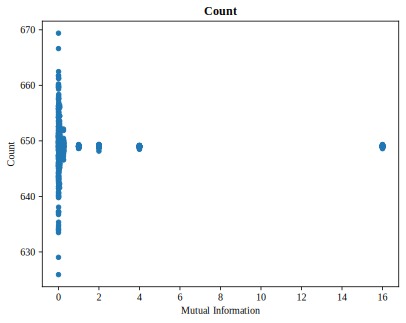

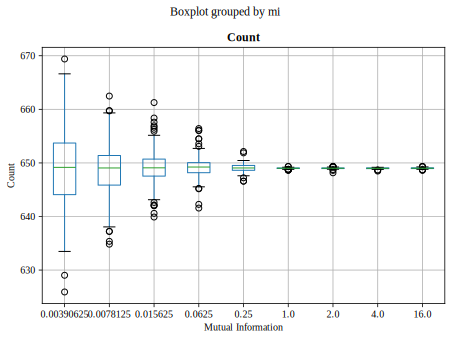

In [10]:
# plot count
fig, ax = plt.subplots()
df.plot.scatter(x='mi', y='count', ax=ax)
ax.set_title('Count')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Count')

# box and whisker plot
fig, ax = plt.subplots()
df.boxplot('count', by='mi', ax=ax)
ax.set_title('Count')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()